<a href="https://colab.research.google.com/github/SawsanDaban/introduction-to-sklearn/blob/main/notebooks/training-loss-func/introduction-to-sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
import pickle
import requests
import tarfile
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import decomposition, ensemble, linear_model, metrics, tree, utils
from sklearn import model_selection, pipeline, preprocessing

# Working with Real Data

When you are just getting started with machine learning it is best to experiment with real-world data (as opposed to artificial data). The following are some good resources of open-source data that you can use for practice or research.

* [University of California-Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/)
* [Kaggle](https://www.kaggle.com/datasets),
* [OpenDataMonitor](http://opendatamonitor.eu/),
* [Wikipedia's list of Machine Learning datasets](https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research)
* [Datasets subreddit](https://www.reddit.com/r/datasets/),
* [Quora's list of open datasets](https://www.quora.com/Where-can-I-find-large-datasets-open-to-the-public)

Major cloud providers all have repositories of publically available datasets.,

* [Open Data on AWS](https://registry.opendata.aws/),
* [Open Data on GCP](https://cloud.google.com/public-datasets/),
* [Open Data on Azure](https://azure.microsoft.com/en-us/services/open-datasets/),
    
Finally, [Pandas DataReader](https://pydata.github.io/pandas-datareader/) provides a unified API to a [number of datasets](https://pydata.github.io/pandas-datareader/remote_data.html). Note that many of these data sources require you to create an account and get an API key.

## MNIST Dataset

The original [MNIST](http://yann.lecun.com/exdb/mnist/) dataset consists of 70000 28x28 black and white images in 10 classes. There are 60000 training images and 10000 test images.

### Download and extract the data

In [2]:
DATA_DIR = pathlib.Path("../data/mnist")
DATA_DIR.mkdir(parents=True, exist_ok=True)
URL = "https://github.com/davidrpugh/introduction-to-machine-learning/blob/main/data/mnist/mnist.parquet?raw=true"

with open(DATA_DIR / "mnist.parquet", 'wb') as f:
    response = requests.get(URL)
    f.write(response.content)


### Load the data

We will load the data using the [Pandas](https://pandas.pydata.org/) library. Highly recommend the most recent edition of [*Python for Data Analysis*](https://learning.oreilly.com/library/view/python-for-data/9781491957653/) by Pandas creator Wes Mckinney for anyone interested in learning how to use Pandas.

In [3]:
data = pd.read_parquet(DATA_DIR / "mnist.parquet")
features = data.drop("label", axis=1)
target = data.loc[:, "label"]

### Explore the data

In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 52.3 MB


In [5]:
features.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
features.tail()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


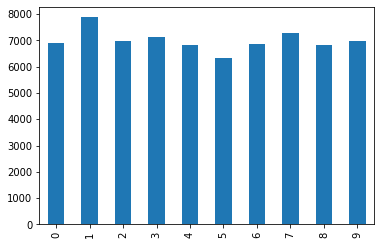

In [8]:
_ = (target.value_counts()
           .sort_index()
           .plot(kind="bar"))

### Visualize the data

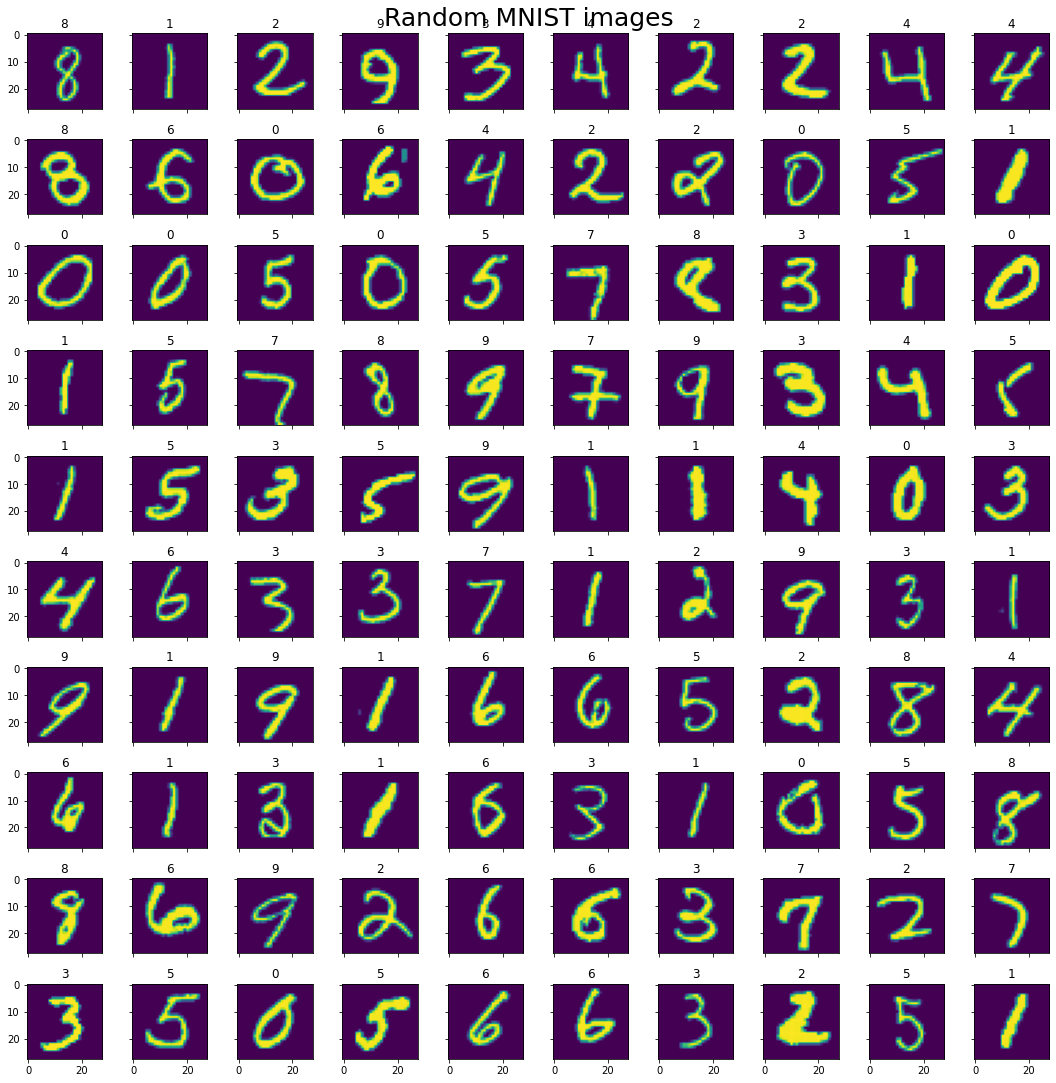

In [9]:
fig, axes = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(15, 15))
for i in range(10):
    for j in range(10):
        m, _ = features.shape
        k = np.random.randint(m)
        img = (features.loc[k, :]
                       .to_numpy()
                       .reshape((28, 28)))
        _ = axes[i, j].imshow(img)
        _ = axes[i, j].set_title(target.iloc[k])

fig.suptitle("Random MNIST images", x=0.5, y=1.0, fontsize=25)
fig.tight_layout()

# Look at the Big Picture

Our goal over these two hands-on workshops will be to build a machine learning modeling pipeline that is capable of classifying images. Today we will mostly focus on classical machine learning algorithms implemented in Scikit-Learn; tomorrow we will revist the same problem using deep learning algorithms implemented in PyTorch. By the time you have finished this two-day workshop you should understand how to build a machine learning application capable of classifying images and be ready to apply what you have learned to a new dataset.

This morning we will mostly focus on getting the data and exploring the data to gain new insights. Believe it or not these initial steps are what data scientists and machine learning engineers spend the majority of their time doing! This afternoon we will prepare our data for machine learning, see how to fit a variety of machine learning models to our dataset and shortlist a few candidate models for further analysis. We will then use hyper-parameter tuning to improve the performance of our shortlisted models to arrive at an overall best model. We will finish with a discussion of how to present the results of your model and talk about some of the aspects of deploying a trained model to make predictions.

## Framing the problem

### What is the business/research objective?

Typically building the model is not the overall objective but rather the model itself is one part of a larger process used to answer a business/research question. Knowing the overall objective is important because it will determine your choice of machine learning algorithms to train, your measure(s) of model performance, and how much time you will spend tweaking the hyper-parameters of your model.

In our example today, the overall business/research objective is to build a tool for reading electricity meter serial numbers which consist of sequences of sometimes handwritten digits. Part of this tool will be a model that can correctly classify individual handwritten digits. Our image classication model is just one of potentially many other models whose predictions are taken as inputs into another machine learning model that will be used to read off the electricity meter serial numbers. 

### What is the current solution?

Always a good idea to know what the current solution to the problem you are trying to solve. Current solution gives a benchmark for performance. Note that the current "best" solution could be very simple or could be very sophisticated. Understanding the current solution helps you think of a good place to start. Example: suppose that the current solution for predicting the price of a house in a given census block is to ignore all the demographic information and predict a simple average of house prices in nearby census blocks. In this case it would probably not make sense to start building a complicated deep learning model to predict housing prices. However, if the current solution was a tuned gradient boosted machine then it probably would not make sense to try a much simpler linear regression model.

With all this information, you are now ready to start designing your system. First, you need to frame the problem by answering the following questions.

* Is our problem `supervised`, unsupervised, or reinforcement learning?
* Is our problem a `classification` task, a regression task, or something else? If our problem is a classification task are we trying to classify samples into 2 categories (binary classification) or more than 2 `(multi-class classification)` categories? If our problem is a regression task, are we trying to predict a single value (univariate regression) or multiple values (multivariate regression) for each sample?
* Should you use `batch learning` or online learning techniques?


### Exercise: Selecting a metric

Scikit-Learn has a number of different [possible metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) that you can choose from (or you can create your own custom metric if required). Can you find a few metrics that seems appropriate for our image classification model?

# Creating a Test Dataset

Before we look at the data any further, we need to create a test set, put it aside, and never look at it (until we are ready to test our trainined machine learning model!). Why? We don't want our machine learning model to memorize our dataset (this is called overfitting). Instead we want a model that will generalize well (i.e., make good predictions) for inputs that it didn't see during training. To do this we hold split our dataset into training and testing datasets. The training dataset will be used to train our machine learning model(s) and the testing dataset will be used to make a final evaluation of our machine learning model(s).

## If you might refresh data in the future...

...then you want to use some particular hashing function to compute the hash of a unique identifier for each observation of data and include the observation in the test set if resulting hash value is less than some fixed percentage of the maximum possible hash value for your algorithm. This way even if you fetch more data, your test set will never include data that was previously included in the training data.

In [10]:
import zlib


def in_testing_data(identifier, test_size):
    _hash = zlib.crc32(bytes(identifier))
    return _hash & 0xffffffff < test_size * 2**32


def split_train_test_by_id(data, test_size, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda identifier: in_testing_data(identifier, test_size))
    return data.loc[~in_test_set], data.loc[in_test_set]


## If this is all the data you will ever have...

...then you can just set a seed for the random number generator and then randomly split the data. Scikit-Learn has a [`model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) module that contains tools for splitting datasets into training and testing sets.

In [11]:
model_selection.train_test_split?

In [12]:
SEED = 42
SEED_GENERATOR = np.random.RandomState(SEED)


def generate_seed():
    return SEED_GENERATOR.randint(np.iinfo("uint16").max)

In [13]:
# split the dataset into training and testing data
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)
train_features, test_features, train_target, test_target = model_selection.train_test_split(
    features,
    target,
    test_size=1e-1,
    random_state=_random_state
)

In [14]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63000 entries, 24297 to 27483
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 47.6 MB


In [15]:
train_features.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
24297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_target.head()

24297    8
36317    1
31132    9
42352    7
16446    5
Name: label, dtype: uint8

In [17]:
train_features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,...,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.0,63000.0,63000.0,63000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.189841,0.090000,0.036111,0.008762,0.007841,0.000921,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.893693,3.965229,2.405637,0.921972,1.213741,0.231078,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,177.000000,254.000000,58.000000,0.0,0.0,0.0,0.0


Again, if you want to you can write out the train and test sets to disk to avoid having to recreate them later.

In [18]:
_ = (train_features.join(train_target)
                   .to_parquet(DATA_DIR / "train.parquet", index=False))

_ = (test_features.join(test_target)
                   .to_parquet(DATA_DIR / "test.parquet", index=False))

# Prepare the data for machine learning algorithms

Best practice is to write functions to automate the process of preparing your data for machine learning. Why?

* Allows you to reproduce these transformations easily on any dataset.
* You will gradually build a library of transformation functions that you can reuse in future projects.
* You can use these functions in a live system to transform the new data before feeding it to your algorithms.
* This will make it possible for you to easily experiment with various transformations and see which combination of transformations works best.

We are working with an benchmark dataset that has already been prepared for analysis (mostly!). You should be aware that academic benchmark datasets are not very representative of the type of datasets that you will encounter in most practical applications. 

## Feature Scaling

Machine learning algorithms typically don’t perform well when the input numerical attributes have very different scales. The simplest approach is to rescale features so that they all reside within the same range (typically between 0 and 1). This approach is implemented in Scikit-Learn by the [`preprocessing.MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) class.

In [19]:
preprocessing.MinMaxScaler?

In [20]:
# hyper-parameters
_preprocessing_hyperparameters = {
    "feature_range": (0, 1),
    "copy": True,
    "clip": False,
}
preprocessor = preprocessing.MinMaxScaler(**_preprocessing_hyperparameters)

In [21]:
preprocessed_train_features = preprocessor.fit_transform(train_features)

In [22]:
preprocessed_train_features.shape

(63000, 784)

In [23]:
preprocessed_train_features[:, :5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [24]:
preprocessed_train_features.min(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [25]:
preprocessed_train_features.mean(axis=0)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.72413793e-05, 2.93713286e-05, 1.58730159e-05, 1.58730159e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.58730159e-05, 3.14083080e-05, 5.33360237e-05, 1.00112486e-04,
       1.46606674e-04, 2.22786875e-04, 4.67538126e-04, 6.46436352e-04,
       7.61282291e-04, 7.99004046e-04, 8.63803299e-04, 7.15468410e-04,
       6.65981948e-04, 5.45845005e-04, 3.47463430e-04, 2.35543106e-04,
       1.92989418e-04, 7.73109244e-05, 5.21911663e-05, 1.70816211e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [26]:
preprocessed_train_features.max(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

The `preprocessing.MinMaxScaler` and the `preprocessing.StandardScaler` classes are the first Scikit-Learn `Transformer` classes that we have encountered. As such now is a good to to discuss the Scikit-Learn application programming interface (API). The [Scikit-Learn API](https://scikit-learn.org/stable/modules/classes.html) is one of the best designed API's around and has heavily influenced API design choices of other libraries in the Python Data Science and Machine Learning ecosystem, in particular [Dask](https://dask.org/) and [NVIDIA RAPIDS](https://rapids.ai/). Familiarly with the Scikit-Learn API will make it easier for you to get started with these libraries.

The Scikit-Learn API is built around the following key concepts.

* Estimators: Any object that can estimate some parameters based on a dataset is called an estimator (e.g., an `preprocessing.MinMaxScaler` is an estimator). The estimation itself is performed by the `fit` method, and it takes only a dataset as a parameter (or two for supervised learning algorithms; the second dataset contains the labels). Any other parameter needed to guide the estimation process is considered a hyperparameter (such as the `feature_range` parameter in `preprocessing.MinMaxScaler`), and it must be set as an instance variable (generally via a constructor parameter).

* Transformers: Some estimators (such as an `preprocessing.MinMaxScaler`) can also transform a dataset; these are called transformers. Once again, the API is simple: the transformation is performed by the transform method with the dataset to transform as a parameter. It returns the transformed dataset. This transformation generally relies on the learned parameters. All transformers also have a convenience method called `fit_transform` that is equivalent to calling `fit` and then `transform` (but sometimes `fit_transform` is optimized and runs much faster).

* Predictors: Finally, some estimators, given a dataset, are capable of making predictions; they are called predictors. A predictor has a `predict` method that takes a dataset of new instances and returns a dataset of corresponding predictions. It also has a score method that measures the quality of the predictions, given a test set (and the corresponding labels, in the case of supervised learning algorithms).

All of an estimator’s hyperparameters are accessible directly via public instance variables (e.g., `preprocessor.feature_range`), and all the estimator’s learned parameters are accessible via public instance variables with an underscore suffix (e.g., `preprocessor.scale_`). Finally, Scikit-Learn provides reasonable default values for most parameters which makes it easy to quickly create a baseline working system.

### Exercise: MinMaxScaler vs StandardScaler

An alternative approach is to rescale features so that they all have zero mean and unit standard deviation. This approach, which is also called standardization, is particularly useful when attributes/features have outliers and when downstream machine learning algorithms assume that attributes/features have a Gaussian or Normal distribution. 

Create an instance of the [`preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class and use it to rescale the training dataset. Compare the two different rescaled versions of the dataset. Which of the two methods do you prefer?

In [27]:
# insert your code here!
_hyperparameters = {
}
preprocessor = preprocessing.StandardScaler(**_hyperparameters)

In [28]:
preprocessed_train_features = preprocessor.fit_transform(train_features)

In [29]:
train_features.mean(axis=0)

pixel1      0.000000
pixel2      0.000000
pixel3      0.000000
pixel4      0.000000
pixel5      0.000000
              ...   
pixel780    0.000921
pixel781    0.000000
pixel782    0.000000
pixel783    0.000000
pixel784    0.000000
Length: 784, dtype: float64

In [30]:
preprocessed_train_features.mean(axis=0)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.20315087e-19, -1.35341473e-18,  1.80455298e-18,  1.35341473e-18,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.76707367e-19,  1.24063017e-18, -9.02276490e-19,  2.48126035e-18,
        2.45306421e-18,  8.45884209e-18,  1.51131312e-17, -3.15796771e-18,
        6.42871999e-18, -1.26318709e-17, -1.08273179e-17, -9.02276490e-19,
        7.89491929e-18,  5.18808982e-18, -1.38725010e-17,  6.76707367e-18,
       -9.02276490e-18,  9.02276490e-19, -4.51138245e-19, -5.78020876e-19,
        0.00000000e+00,  

In [31]:
preprocessed_train_features.std(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).

## Feature Engineering

Feature engineering is one of the most important parts of any machine learning project. There are two main tasks in feature engineering.

* Feature selection: selecting the best subset of features for training. 
* Feature extraction: combining existing features to produce new features for training.
* Feature creation: finding additional data sources to use as features.

Feature engineering is often the most labor intensive part of building a machine learning pipeline and often requires extensive expertise/domain knowledge relevant to the problem at hand. Recently packages such as [featuretools](https://www.featuretools.com/) have been developed to (partially) automate the process of feature engineering.

The success of deep learning in various domains is in significant part due to the fact that deep learning models are able to automatically engineer features that are most useful for solving certain machine learning tasks. In effect deep learning replaces the expensive to acquire expertise/domain knowledge required to hand-engineer predictive features. 

A recent example that demonstrates that power of automated feature engineering is [Space2vec](https://medium.com/dessa-news/space-2-vec-fd900f5566), a deep learning based supernovae classifier developed by machine learning engineers with no expertise in Astronomy that was able to outperform the machine learning solution developed by NERSC scientists. The machine learning pipeline developed by NERSC scientists, called [AUTOSCAN](https://portal.nersc.gov/project/dessn/autoscan/), was a significant improvement over the previous solution which relied on manual classification of supernovae by astronomers. However, in order to achieve such high accuracy, the NERSC solution relied on a dataset of hand-engineered features developed by astronomers with over a century of combined training and expertise in the domain. The deep learning algorithm used by space2vec could be applied directly to the raw image data and did not rely on any hand-engineered features.

### Feature Selection

In [32]:
minimum_threshold = 0 # maybe something greater than 0?
# what is the usefull threshold 0, 10, 100, etc
useful_pixels = train_features.sum(axis=0) > minimum_threshold
useful_features = train_features.loc[:, useful_pixels]

In [33]:
useful_features.head()

,pixel13,pixel14,pixel15,pixel16,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780
24297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
useful_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63000 entries, 24297 to 27483
Columns: 716 entries, pixel13 to pixel780
dtypes: uint8(716)
memory usage: 45.5 MB


### Feature extraction using Principal Component Analysis (PCA)

In [35]:
decomposition.PCA?

In [36]:
_seed = generate_seed()

# hyper-parameters
_pca_hyperparameters = {
    "n_components": 0.95,
    "whiten": False,
}

decomposer = decomposition.PCA(**_pca_hyperparameters)
engineered_train_features = decomposer.fit_transform(preprocessed_train_features)

In [37]:
engineered_train_features.shape

(63000, 330)

In [38]:
engineered_train_features[:, :5]

array([[ -0.86103111, -11.79493615,  -1.27048469,  -4.9719654 ,
          2.77780145],
       [ -8.4063675 ,  -1.67360331,   2.95180512,   0.01904345,
          3.02835524],
       [ -6.20328956,   2.16176533,  -3.17360168,  -2.08268583,
         -4.85582224],
       ...,
       [  5.54889524,  -0.40414232,  -2.24668888,  -6.30196758,
         -3.28264033],
       [ -7.24144148,   0.56048745,   1.40055848,  -0.34550077,
          1.00644112],
       [  8.22011559,   3.91438171,   1.94311882,  14.87553756,
         -2.43939191]])

In [39]:
engineered_train_features.mean(axis=0)

array([ 3.92490273e-17, -4.25874503e-16, -6.52345902e-16,  1.73237086e-16,
        1.35341473e-17, -2.03237779e-16,  1.57898386e-17,  1.08273179e-17,
       -1.33762490e-16, -4.96252069e-17,  2.45870343e-17, -2.97751242e-17,
       -9.72202918e-17,  1.13686838e-16,  5.84224027e-17,  2.66171565e-17,
       -1.17295944e-17, -1.84966680e-17,  8.16560223e-17, -4.22942105e-17,
       -4.60161010e-17, -2.97751242e-17,  3.33842301e-17,  6.76707367e-17,
       -2.97751242e-17,  3.60910596e-17, -2.03012210e-17, -5.27831747e-17,
        5.18808982e-17, -4.21814259e-17, -7.17309809e-17,  1.71432533e-17,
       -5.41365894e-18, -2.50381726e-17,  5.81968336e-17, -2.03012210e-17,
       -7.03775662e-17, -7.44378104e-17,  8.88742343e-17,  5.27831747e-17,
       -9.92504139e-18, -9.92504139e-18,  4.32528792e-17, -5.18808982e-18,
        3.15796771e-17,  1.80455298e-18, -2.70682947e-18,  5.41365894e-17,
       -2.17674203e-17,  9.36111858e-18,  6.31593543e-18,  3.92490273e-17,
       -8.66185430e-17,  

In [40]:
engineered_train_features.std(axis=0)

array([6.36141054, 5.39134295, 5.19063514, 4.56241901, 4.26080008,
       3.95788835, 3.71032431, 3.53793546, 3.3201303 , 3.17031157,
       3.1045953 , 2.93992664, 2.83410864, 2.80005772, 2.71976546,
       2.67580049, 2.58926632, 2.5747835 , 2.53004232, 2.49534137,
       2.43214704, 2.39904381, 2.34049928, 2.30874595, 2.27272577,
       2.23226682, 2.21606543, 2.16561749, 2.12853469, 2.09974032,
       2.07672909, 2.05786445, 2.02009743, 2.01361768, 1.99967045,
       1.96499526, 1.94742243, 1.92657921, 1.91070534, 1.85596723,
       1.85309632, 1.83424453, 1.80670853, 1.79398969, 1.78681542,
       1.78240998, 1.7746789 , 1.75754126, 1.75507359, 1.73839485,
       1.70472365, 1.69022482, 1.68871553, 1.675172  , 1.66559831,
       1.65095927, 1.63929273, 1.62915799, 1.6110124 , 1.60332645,
       1.58531476, 1.57685275, 1.57262665, 1.56732145, 1.5553493 ,
       1.54756758, 1.53980703, 1.51798622, 1.51020126, 1.50419743,
       1.49287243, 1.48360059, 1.48077969, 1.47517972, 1.45792

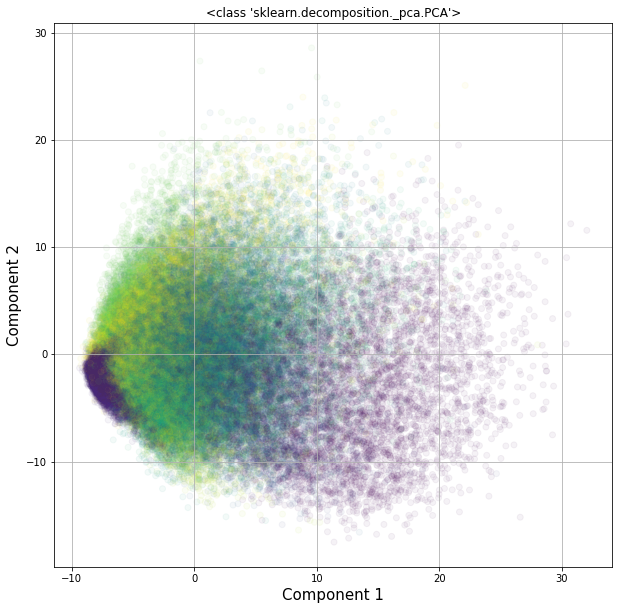

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
_ = ax.scatter(
    engineered_train_features[:, 0],
    engineered_train_features[:, 1],
    c=train_target,
    alpha=0.05
)
_ = ax.set_xlabel("Component 1", fontsize=15)
_ = ax.set_ylabel("Component 2", fontsize=15)
_ = ax.set_title(type(decomposer))
_ = ax.grid(True)

### Exercise: To whiten, or not to whiten?

Take a close look at the doc string for the `decomposition.PCA` algorithm. What happens if you set `n_components` to a number between 0 and 1 (i.e., `n_components=0.95`)? Why might you want to do this? What does setting `whiten=True` do to the output of the algorithm? Re-run the PCA algorithm above setting `whiten=True` to confirm your answer. Why might you want to set `whiten=True`? 

In [42]:
# insert code here!

## Transformation pipelines

As you can see creating preprocessing pipelines involves quite a lot of steps and each of the steps needs to be executed in the correct order. Fortunately Scikit-Learn allows you to combine estimators together to create [pipelines](https://scikit-learn.org/stable/modules/compose.html#combining-estimators). We can encapsulate all of the preprocessing logic into instances of the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class.

The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a `fit_transform` method). The names can be anything you like (as long as they are unique). Later we will see how to access the parameters of pipelines using these names when we discuss hyperparameter tuning.

In [43]:
_seed = generate_seed()

# hyper-parameters
_min_max_scaler_hyperparameters = {
    "feature_range": (0, 1)
}

_pca_hyperparameters = {
    "n_components": 154,
    "random_state": np.random.RandomState(_seed),
    "svd_solver": "randomized",
    "whiten": False,
}

# default Pipeline constructor
preparation_pipeline = pipeline.Pipeline(
    [
        ("minmaxscaler", preprocessing.MinMaxScaler(**_min_max_scaler_hyperparameters)),
        ("pca", decomposition.PCA(**_pca_hyperparameters)),
    ],
    verbose=True,
)

In [44]:
_seed = generate_seed()

# hyper-parameters
_min_max_scaler_hyperparameters = {
    "feature_range": (0, 1)
}

_pca_hyperparameters = {
    "n_components": 154,
    "random_state": np.random.RandomState(_seed),
    "svd_solver": "randomized",
    "whiten": False,
}

# alternative constructor that is equivalent to the above!
preparation_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(**_min_max_scaler_hyperparameters),
    decomposition.PCA(**_pca_hyperparameters),
    verbose=True,
)

In [45]:
prepared_train_features = preparation_pipeline.fit_transform(train_features)

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing pca, total=   8.2s


In [46]:
prepared_train_features.min(axis=0)

array([-4.24574763, -5.61415758, -5.59676855, -5.98058498, -5.15265024,
       -4.83938968, -4.38667085, -4.50165676, -4.27547114, -3.92259614,
       -3.20958845, -3.99455016, -3.54669965, -3.71066641, -3.78488795,
       -4.06420072, -3.46728319, -3.64304059, -3.68931442, -2.99660746,
       -3.00361906, -3.37429972, -2.79074283, -2.74593579, -2.90747635,
       -3.21047594, -2.65675938, -2.60517035, -2.71063113, -2.55561263,
       -2.69944861, -2.39994877, -2.57480867, -2.41924801, -2.44013455,
       -2.38527772, -2.32592405, -2.17314668, -2.2604682 , -2.13167204,
       -2.15252362, -1.91066976, -2.28625874, -2.07611741, -2.15516347,
       -1.94244375, -1.95229674, -1.95006655, -1.83884287, -1.84989617,
       -2.04049692, -1.92049925, -1.9234359 , -2.03063567, -1.94603206,
       -1.6425317 , -1.69927541, -1.72360836, -1.78315021, -1.7232653 ,
       -1.55360158, -1.80117654, -1.60636263, -1.47159324, -1.47961436,
       -1.60085633, -1.5104819 , -1.4837272 , -1.53038857, -1.49

In [47]:
prepared_train_features.mean(axis=0)

array([ 3.88493470e-16, -1.11487539e-16, -1.23789867e-16,  4.65024844e-16,
        5.03089633e-16, -2.52710110e-16,  1.70509109e-16, -1.80839470e-16,
        4.08243765e-16, -2.58345373e-16,  2.47789443e-16, -2.71468914e-16,
        4.43155213e-17,  1.03725670e-16, -7.28405872e-16,  3.84748670e-16,
        3.93889507e-16, -6.28706963e-16, -3.78067947e-16, -6.26692701e-16,
        1.18289858e-16,  3.46241554e-16,  2.32273636e-16,  2.85214533e-16,
       -7.52554985e-16, -4.70499301e-16,  9.21895056e-16, -5.08492719e-16,
        2.00388207e-16, -2.56281768e-16, -1.39071382e-15,  2.94667289e-17,
       -5.13963651e-16,  2.46340426e-16, -2.51902555e-16,  4.25120256e-16,
       -4.46270005e-17, -3.73070181e-17, -4.86097053e-16,  1.49891387e-15,
       -6.84951214e-16,  1.06389324e-15,  1.29120700e-17, -2.51817967e-16,
        4.11182772e-16, -4.26910051e-16,  1.04300827e-16,  3.66708427e-17,
        1.93524209e-16, -4.82843042e-16,  6.28944868e-16,  6.55486247e-16,
       -6.05690101e-16,  

In [48]:
prepared_train_features.max(axis=0)

array([9.34452731, 5.71965372, 5.79691075, 6.21999241, 5.49879536,
       5.09711872, 4.96831235, 4.67198929, 5.7905303 , 4.02031097,
       4.28011425, 4.25994013, 4.17749019, 4.02509707, 3.79155447,
       4.20602438, 3.54056965, 4.02387844, 3.82681285, 3.76421724,
       3.33364602, 3.49577005, 2.83415428, 3.0251777 , 3.10613391,
       3.55606752, 2.92082782, 3.14074888, 2.90917566, 2.91080984,
       2.87076598, 2.66536953, 2.5850386 , 2.58728139, 2.66314647,
       2.69426667, 2.84355296, 2.41900068, 2.76148195, 2.42453586,
       2.44757987, 2.19254704, 2.44053771, 2.35950765, 2.52347971,
       2.05704239, 2.08960591, 2.26337667, 2.21088839, 1.98083226,
       2.0739539 , 2.14280843, 1.98909073, 2.03226204, 2.17966634,
       1.6554997 , 1.99747122, 1.91055208, 1.83239186, 1.95887844,
       2.0048478 , 2.08233263, 1.65392872, 1.88328755, 1.60333489,
       1.85594819, 1.75787743, 1.60125156, 1.72521679, 1.75928195,
       1.68361511, 1.51096883, 1.54850987, 1.55536575, 1.42721

### Exercise: Feature scaling prior to using PCA?

Do you think that it is necessary to rescale the raw features prior to using PCA? Why or why not?

`No` ` We do not need to rescale we can just skip the step and use the pca.` `listen to the voice recorder... min 20`

# Select and train a model

At last! You framed the problem, you got the data and explored it, you sampled a training set and a test set, and you wrote transformation pipelines to clean up and prepare your data for machine learning algorithms automatically. You are now ready to select and train a Machine Learning model. You might have been wondering if we were every going to make it to this point! Fact is, most of your time developing machine learning solutions to real-world problems will not be spent training machine learning models: most of your time will be spent preparing the data for machine learning algorithms and most of the computer time will be spent training the machine learning models.

## Training and evaluating on the training dataset

### Linear models

In [49]:
# hyper-parameters
_min_max_scaler_hyperparameters = {
    "feature_range": (0, 1)
}

preparation_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(**_min_max_scaler_hyperparameters),
    verbose=True,
)

In [50]:
prepared_train_features = preparation_pipeline.fit_transform(train_features)

[Pipeline] ...... (step 1 of 1) Processing minmaxscaler, total=   0.4s


In [51]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "fit_intercept": True,
    "loss": "log",
    "penalty": None,
    "random_state": np.random.RandomState(_seed),
}
estimator = linear_model.SGDClassifier(**_classifier_hyperparameters)
_ = estimator.fit(prepared_train_features, train_target)

In [52]:
predictions = estimator.predict(prepared_train_features)

In [53]:
predictions

array([8, 1, 9, ..., 8, 1, 6], dtype=uint8)

Congrats! You have fit your first machine learning model using Scikit-Learn and made some predictions. Now let's see how good those predictions really are.

### Evaluation metrics

#### Confusion matrix

In [54]:
confusion_matrix = metrics.confusion_matrix(
    train_target,
    predictions,
)
confusion_matrix

array([[5955,    1,   25,   12,   10,   50,   26,    9,   98,    6],
       [   0, 6835,   45,   29,    7,   48,    7,   12,   81,   19],
       [  35,   43, 5586,  136,   50,   49,   67,   63,  215,   20],
       [  19,   18,  155, 5606,   11,  217,   12,   52,  217,  101],
       [  12,   10,   47,   21, 5707,   42,   29,   26,  130,  189],
       [  47,   19,   33,  205,   52, 4958,   86,   23,  202,   71],
       [  26,   12,   59,   16,   30,  147, 5761,   13,   97,    2],
       [  18,   10,   55,   29,   48,   20,    1, 6121,   48,  229],
       [  36,   85,   89,  148,   35,  199,   37,   25, 5349,  118],
       [  21,   31,   13,   91,  200,   74,    1,  230,  116, 5504]])

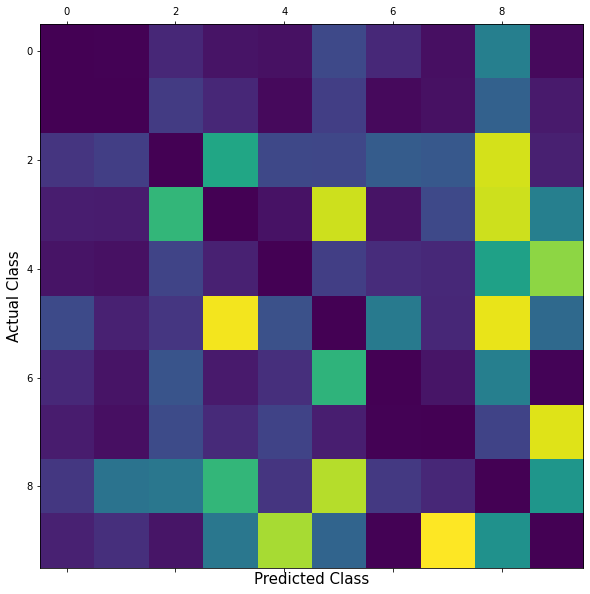

In [55]:
# visualize the normalized confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
_normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(_normalized_confusion_matrix, 0)
_ = ax.matshow(_normalized_confusion_matrix)
_ = ax.set_xlabel("Predicted Class", fontsize=15)
_ = ax.set_ylabel("Actual Class", fontsize=15)
plt.show()

#### Precision

In [56]:
metrics.precision_score(
    train_target,
    predictions,
    average="macro",
)

0.9103216125073615

#### Recall

In [57]:
metrics.recall_score(
    train_target,
    predictions,
    average="macro",
)

0.909763803165799

#### $F_1$ Score

In [58]:
metrics.f1_score(
    train_target,
    predictions,
    average="macro",
)

0.9099001792065229

#### Receiver Operating Characteristic (ROC) Area Under the Curve (AUC) Score

In [59]:
_scores = estimator.predict_proba(prepared_train_features)
metrics.roc_auc_score(
    train_target,
    _scores,
    average="macro",
    multi_class="ovo",
)

0.9873846128628074

#### Classification report

In [60]:
_report = metrics.classification_report(
    train_target,
    predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      6192
           1       0.97      0.96      0.97      7083
           2       0.91      0.89      0.90      6264
           3       0.89      0.87      0.88      6408
           4       0.93      0.92      0.92      6213
           5       0.85      0.87      0.86      5696
           6       0.96      0.93      0.95      6163
           7       0.93      0.93      0.93      6579
           8       0.82      0.87      0.84      6121
           9       0.88      0.88      0.88      6281

    accuracy                           0.91     63000
   macro avg       0.91      0.91      0.91     63000
weighted avg       0.91      0.91      0.91     63000



### Accelerating training

How can we speed up training? Use more cores and/or some other [dimensionality reduction](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) technique to reduce the dimension of the feature space.

In [68]:
_seed = generate_seed()
_pca_hyperparameters = {
    "n_components": 330, #154
    "random_state": np.random.RandomState(_seed),
    "svd_solver": "randomized",
    "whiten": True
}

# use PCA to reduce dimensionality and standardize features
_preparation_pipeline = pipeline.make_pipeline(
    decomposition.PCA(**_pca_hyperparameters),
    verbose=True,
)
prepared_train_features = _preparation_pipeline.fit_transform(train_features)

[Pipeline] ............... (step 1 of 1) Processing pca, total=  17.3s


In [69]:
train_features.shape

(63000, 784)

In [70]:
prepared_train_features.shape

(63000, 330)

In [71]:
prepared_train_features.mean(axis=0)

array([ 5.74743075e-17, -7.09591116e-17, -2.50471601e-16,  1.06680097e-16,
        7.17750374e-17, -3.07892160e-16, -5.56614719e-16,  6.61269981e-17,
        1.04296862e-16,  3.24149878e-17,  1.24690381e-16, -2.93095354e-16,
        2.02495868e-16, -8.28980623e-16,  9.38828821e-16, -9.26683774e-17,
        3.27924636e-16, -6.65710873e-17, -6.86304629e-16,  2.65974192e-16,
       -8.06673952e-16, -1.86608753e-15, -3.57119977e-16,  1.13940603e-15,
        2.67835137e-16,  1.31802505e-15,  3.85276907e-16, -1.71601005e-15,
        7.79788932e-16,  3.68978569e-15, -3.12861377e-15,  1.10093768e-15,
       -6.56355041e-16, -4.04537074e-16,  2.07216960e-16, -7.79711392e-17,
       -2.41158945e-16,  2.93528870e-16,  1.85747361e-16, -3.60607487e-16,
        8.24349407e-17, -3.90065405e-16, -3.96323186e-16, -1.08322522e-16,
        1.96439470e-15, -5.50208908e-16,  1.52507989e-15,  1.27651681e-15,
       -2.52786152e-15,  5.73664573e-16, -1.11025122e-15, -1.12930917e-15,
        4.45372134e-16, -

In [72]:
prepared_train_features.std(axis=0)

array([0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999206,
       0.99999206, 0.99999206, 0.99999206, 0.99999206, 0.99999

In [73]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "fit_intercept": False,
    "loss": "log",
    "n_jobs": -1,
    "penalty": None,
    "random_state": np.random.RandomState(_seed),
}
_estimator = linear_model.SGDClassifier(**_classifier_hyperparameters)
_ = _estimator.fit(prepared_train_features, train_target)

# make predictions
_predictions = _estimator.predict(prepared_train_features)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.79      0.94      0.86      6192
           1       0.76      0.97      0.85      7083
           2       0.81      0.76      0.79      6264
           3       0.77      0.78      0.77      6408
           4       0.79      0.83      0.81      6213
           5       0.73      0.62      0.67      5696
           6       0.92      0.78      0.85      6163
           7       0.80      0.80      0.80      6579
           8       0.77      0.65      0.71      6121
           9       0.75      0.69      0.72      6281

    accuracy                           0.79     63000
   macro avg       0.79      0.78      0.78     63000
weighted avg       0.79      0.79      0.78     63000



### Exercise: experiment with different loss functions

In [67]:
linear_model.SGDClassifier?

In [76]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "fit_intercept": False,
    "loss": "perceptron", # change this! ( "loss": "hinge" )
    "n_jobs": -1,
    "penalty": None,
    "random_state": np.random.RandomState(_seed),
}
_estimator = linear_model.SGDClassifier(**_classifier_hyperparameters)
_ = _estimator.fit(prepared_train_features, train_target)

# make predictions
_predictions = _estimator.predict(prepared_train_features)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.68      0.85      0.75      6192
           1       0.66      0.91      0.76      7083
           2       0.67      0.67      0.67      6264
           3       0.65      0.56      0.60      6408
           4       0.59      0.61      0.60      6213
           5       0.52      0.56      0.54      5696
           6       0.91      0.46      0.61      6163
           7       0.68      0.74      0.71      6579
           8       0.53      0.52      0.52      6121
           9       0.54      0.40      0.45      6281

    accuracy                           0.63     63000
   macro avg       0.64      0.63      0.62     63000
weighted avg       0.64      0.63      0.63     63000



### Exercise: experiment with different penalties

In [63]:
linear_model.SGDClassifier?

In [64]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "alpha": 1e-4, # try changing this!
    "fit_intercept": False,
    "l1_ratio": 0.15, # only used for penalty=elastic_net
    "loss": "log",
    "n_jobs": -1,
    "penalty": None, # try changing this!
    "random_state": np.random.RandomState(_seed),
}
_estimator = linear_model.SGDClassifier(**_classifier_hyperparameters)
_ = _estimator.fit(prepared_train_features, train_target)

# make predictions
_predictions = _estimator.predict(prepared_train_features)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      6192
           1       0.78      0.96      0.86      7083
           2       0.79      0.76      0.77      6264
           3       0.79      0.74      0.76      6408
           4       0.84      0.83      0.83      6213
           5       0.78      0.60      0.68      5696
           6       0.81      0.88      0.84      6163
           7       0.75      0.87      0.80      6579
           8       0.79      0.65      0.71      6121
           9       0.79      0.67      0.73      6281

    accuracy                           0.79     63000
   macro avg       0.79      0.79      0.79     63000
weighted avg       0.79      0.79      0.79     63000



### Mini-batch gradient descent

Since we talked about the difference between stochastic, batch, and mini-batch gradient descent in the lectures I wanted you to see how to implement mini-batch gradient descent in Scikit-Learn. You will see much more of this idea in the deep learning hands on session so we will not spend too much time on it now.

In [65]:
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)

n_epochs = 2
batch_size = 128
X = prepared_train_features
y = train_target
m, _ = X.shape

# define your estimator
_classifier_hyperparameters = {
    "alpha": 1e-4,
    "fit_intercept": False,
    "l1_ratio": 0.15,
    "learning_rate": "optimal",
    "loss": "log",
    "n_jobs": -1,
    "penalty": None,
    "random_state": _random_state,
    "warm_start": True,
}
estimator = linear_model.SGDClassifier(**_classifier_hyperparameters)

# nested for loops implement the training
for _ in range(n_epochs):

    # shuffle the dataset before every training epoch
    shuffled_indices = _random_state.permutation(m)
    _X, _y = X[shuffled_indices], y.iloc[shuffled_indices]

    for batch_ixs in utils.gen_batches(m, batch_size):
        _ = estimator.partial_fit(_X[batch_ixs], _y[batch_ixs], classes=y.unique())


In [66]:
# make predictions
_predictions = estimator.predict(prepared_train_features)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      6192
           1       0.77      0.88      0.82      7083
           2       0.67      0.69      0.68      6264
           3       0.76      0.61      0.68      6408
           4       0.69      0.67      0.68      6213
           5       0.59      0.49      0.53      5696
           6       0.75      0.80      0.77      6163
           7       0.66      0.84      0.74      6579
           8       0.59      0.57      0.58      6121
           9       0.69      0.49      0.58      6281

    accuracy                           0.70     63000
   macro avg       0.69      0.69      0.69     63000
weighted avg       0.69      0.70      0.69     63000



### Discussion

What is going on here? Are we underfitting? Are we overfitting? If you think that we are underfitting, then what could we do to try and get the model to overfit? If we are overfitting, what could we do to get the model to underfit?

In [67]:
CV_FOLDS = 3

In [68]:
model_selection.learning_curve?

ERROR:root:Exception raised in ColabInspector._getdef
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/_inspector.py", line 385, in _getdef
    if v.default != v.empty:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


In [69]:
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)
_classifier_hyperparameters = {
    "fit_intercept": False,
    "loss": "log",
    "n_jobs": -1,
    "penalty": None,
    "random_state": _random_state,
}
_estimator = linear_model.SGDClassifier(**_classifier_hyperparameters)
_ = _estimator.fit(prepared_train_features, train_target)

train_sizes, train_scores, val_scores = model_selection.learning_curve(
    _estimator,
    prepared_train_features,
    train_target,
    cv=CV_FOLDS,
    n_jobs=-1,
    random_state=_random_state,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 15),
    verbose=1,
)

[learning_curve] Training set sizes: [ 4200  6900  9600 12300 15000 17700 20400 23100 25800 28500 31200 33900
 36600 39300 42000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 10.4min finished


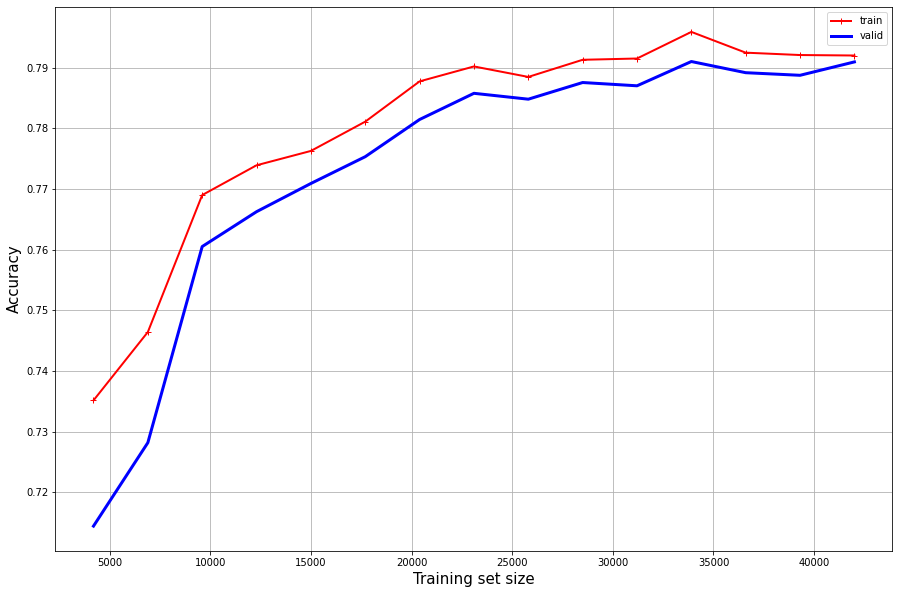

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(train_sizes, train_scores.mean(axis=1), "r-+", linewidth=2, label="train")
ax.plot(train_sizes, val_scores.mean(axis=1), "b-", linewidth=3, label="valid")
ax.set_xlabel("Training set size", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
ax.grid()
ax.legend()

plt.show()

### Decision Trees

[Decision Trees](https://scikit-learn.org/stable/modules/tree.html) are a non-parametric supervised learning method used for [classification](https://scikit-learn.org/stable/modules/tree.html#tree-classification) and [regression](https://scikit-learn.org/stable/modules/tree.html#tree-regression). The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [71]:
tree.DecisionTreeClassifier?

In [72]:
_seed = generate_seed()

_classifier_hyperparameters = {
    "random_state": np.random.RandomState(_seed)
}

estimator = tree.DecisionTreeClassifier(**_classifier_hyperparameters)

# here we fit using the raw training features
_ = estimator.fit(train_features, train_target)

In [73]:
# make predictions
_predictions = estimator.predict(train_features)

# report the accuracy on the training data
_report = metrics.classification_report(
    train_target,
    _predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6192
           1       1.00      1.00      1.00      7083
           2       1.00      1.00      1.00      6264
           3       1.00      1.00      1.00      6408
           4       1.00      1.00      1.00      6213
           5       1.00      1.00      1.00      5696
           6       1.00      1.00      1.00      6163
           7       1.00      1.00      1.00      6579
           8       1.00      1.00      1.00      6121
           9       1.00      1.00      1.00      6281

    accuracy                           1.00     63000
   macro avg       1.00      1.00      1.00     63000
weighted avg       1.00      1.00      1.00     63000



Wait, what!? No error at all? Could this model really be absolutely perfect? Unfortunately it is much more likely that the model has badly overfit the training data. How can you be sure? As we saw earlier, you don’t want to touch the testing dataset until you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.

The following code use Scikit-Learn [`model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) to randomly split the training set into 5 distinct subsets called folds, then it trains and evaluates our model 5 times, picking a different fold for evaluation every time and training on the other 4 folds. The result is an array containing the 5 evaluation scores.

In [74]:
estimator_scores = model_selection.cross_val_score(
    estimator,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.5s finished


In [75]:
estimator_scores.mean()

0.8621587301587302

### Understanding Feature Importance

One of the nice features of decision trees is that they provide a way to measure the importance of each of feature. Understanding feature importance is a topic all unto itself. If you are interested in pulling this thread, then I recommend that you start with [SHapley Additive Explanations (SHAP)](https://shap.readthedocs.io/en/latest/index.html) and then take a look through [*Interpretable Machine Learning*](https://christophm.github.io/interpretable-ml-book/).

In [76]:
estimator.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.49277613e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.14143701e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [77]:
is_positive = estimator.feature_importances_ > 0
is_positive.sum() / estimator.feature_importances_.size

0.6377551020408163

Because our features are pixels we can reshape and plot the features to gain some insight into what might be driving feature importance.

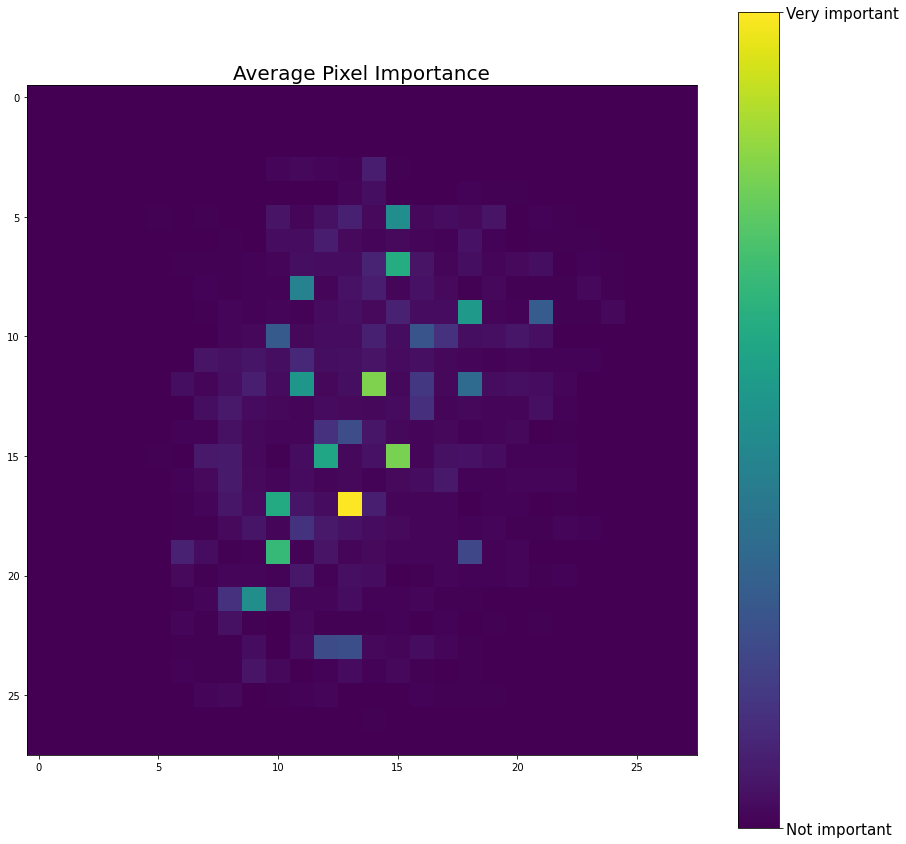

In [78]:
_, ax = plt.subplots(1, 1, figsize=(15, 15))
_average_pixel_importances = (
    estimator.feature_importances_
             .reshape((1, 28, 28))
             .mean(axis=0)
)
plt.imshow(_average_pixel_importances)
plt.title("Average Pixel Importance", fontsize=20)

# create a colorbar
colorbar = plt.colorbar(ticks=[_average_pixel_importances.min(), _average_pixel_importances.max()])
_ = (colorbar.ax
             .set_yticklabels(["Not important", "Very important"], fontsize=15))

The majority of features seem to be unimportant which suggests that perhaps we should look at ways to extract the most important features prior to fitting our decision tree model. The code below creates a preprocessing pipeline that uses PCA to reduce the dimension of the feature space and extract more meaningful input features and retrain a decision tree classifier. Does this improve the results?

In [79]:
# use PCA to reduce dimensionality and standardize features
_seed = generate_seed()
_pca_hyperparameters = {
    "n_components": 154,
    "random_state": np.random.RandomState(_seed),
    "svd_solver": "randomized",
    "whiten": False,
}
_preparation_pipeline = pipeline.make_pipeline(
    decomposition.PCA(**_pca_hyperparameters),
    verbose=True,
)
prepared_train_features = _preparation_pipeline.fit_transform(train_features)

# fit decision tree classifier
estimator = tree.DecisionTreeClassifier(random_state=_random_state,)
_ = estimator.fit(prepared_train_features, train_target)

# generate a classification report
_predictions = estimator.predict(prepared_train_features)
_report = metrics.classification_report(
    train_target,
    _predictions,
)
print(_report)

# use cross validation to estimate generalization error
estimator_scores = model_selection.cross_val_score(
    estimator,
    X=prepared_train_features,
    y=train_target,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

print(f"Average validation error: {estimator_scores.mean()}")

[Pipeline] ............... (step 1 of 1) Processing pca, total=   9.3s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6192
           1       1.00      1.00      1.00      7083
           2       1.00      1.00      1.00      6264
           3       1.00      1.00      1.00      6408
           4       1.00      1.00      1.00      6213
           5       1.00      1.00      1.00      5696
           6       1.00      1.00      1.00      6163
           7       1.00      1.00      1.00      6579
           8       1.00      1.00      1.00      6121
           9       1.00      1.00      1.00      6281

    accuracy                           1.00     63000
   macro avg       1.00      1.00      1.00     63000
weighted avg       1.00      1.00      1.00     63000



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Average validation error: 0.818047619047619


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.6s finished


### Exercise: Regularizing Decision Trees

Our decision tree classifier appears to be overfitting. We need to regularize it. Decreasing `max_*` parameters and increasing `min_*` parameters will increase the amount of regularization applied to the model and will help reduce overfitting.

In [80]:
tree.DecisionTreeClassifier?

In [81]:
# fit decision tree classifier
_seed = generate_seed()
_classifier_hyperparameters = {
    "criterion": "entropy",
    "max_depth": 32,
    "max_features": "sqrt",
    "min_samples_leaf": 1e-3,
    "min_samples_split": 2e-3,
    "random_state": np.random.RandomState(_seed)
}
estimator = tree.DecisionTreeClassifier(**_classifier_hyperparameters)
_ = estimator.fit(prepared_train_features, train_target)

# make predictions
_predictions = estimator.predict(prepared_train_features)

# create a classification report
_report = metrics.classification_report(
    train_target,
    _predictions,
)
print(_report)

# use cross validation to estimate generalization error
estimator_scores = model_selection.cross_val_score(
    estimator,
    X=prepared_train_features,
    y=train_target,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

print(f"Average validation error: {estimator_scores.mean()}")

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      6192
           1       0.83      0.91      0.87      7083
           2       0.71      0.70      0.70      6264
           3       0.62      0.61      0.61      6408
           4       0.67      0.69      0.68      6213
           5       0.62      0.58      0.60      5696
           6       0.71      0.79      0.75      6163
           7       0.78      0.74      0.76      6579
           8       0.62      0.61      0.62      6121
           9       0.64      0.61      0.63      6281

    accuracy                           0.70     63000
   macro avg       0.70      0.70      0.70     63000
weighted avg       0.70      0.70      0.70     63000



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Average validation error: 0.6617460317460317


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished


### Exercise

Compute the normalized confusion matrix for your decision tree classifier and plot it. Do you notice any patterns? What are the three classes for which your decision tree classifier peforms the worst?

In [82]:
# insert code here!

### Ensemble Methods

Building a model on top of many other models is called [ensemble](https://scikit-learn.org/stable/modules/ensemble.html) learning and it is often a great approach to improve the predictions of your machine learning pipeline.

#### Random Forests

Let’s try the [`ensemble.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Random forests work by training many decision trees on random subsets of the features, then averaging the predictions made by each of the decision trees to arrive at an overall prediction.

In [83]:
ensemble.RandomForestClassifier?

In [84]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "n_jobs": -1,
    "random_state": np.random.RandomState(_seed)
}

estimator = ensemble.RandomForestClassifier(**_classifier_hyperparameters)
_ = estimator.fit(train_features, train_target)

In [85]:
# make predictions
_predictions = estimator.predict(train_features)

# generate a classification report
_report = metrics.classification_report(
    train_target,
    _predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6192
           1       1.00      1.00      1.00      7083
           2       1.00      1.00      1.00      6264
           3       1.00      1.00      1.00      6408
           4       1.00      1.00      1.00      6213
           5       1.00      1.00      1.00      5696
           6       1.00      1.00      1.00      6163
           7       1.00      1.00      1.00      6579
           8       1.00      1.00      1.00      6121
           9       1.00      1.00      1.00      6281

    accuracy                           1.00     63000
   macro avg       1.00      1.00      1.00     63000
weighted avg       1.00      1.00      1.00     63000



##### Visualizing Feature Importance

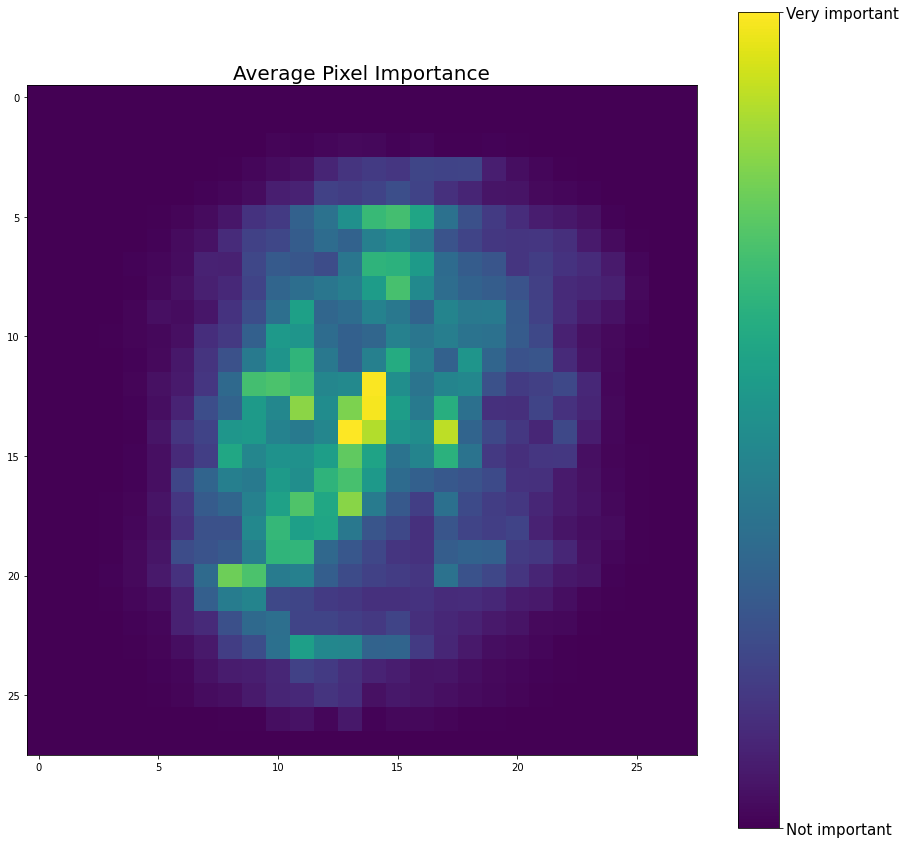

In [86]:
_, ax = plt.subplots(1, 1, figsize=(15, 15))
_average_pixel_importances = (
    estimator.feature_importances_
             .reshape((1, 28, 28))
             .mean(axis=0)
)
plt.imshow(_average_pixel_importances)
plt.title("Average Pixel Importance", fontsize=20)

# create a colorbar
colorbar = plt.colorbar(ticks=[_average_pixel_importances.min(), _average_pixel_importances.max()])
_ = (colorbar.ax
             .set_yticklabels(["Not important", "Very important"], fontsize=15))

##### Measuring Validation Error

Again you can use $k$-fold CV to estimate the validation error for your random forest classifier.

In [87]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "n_jobs": -1,
    "random_state": np.random.RandomState(_seed)
}

estimator = ensemble.RandomForestClassifier(**_classifier_hyperparameters)

estimator_scores = model_selection.cross_val_score(
    estimator,
    X=train_features,
    y=train_target,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


In [88]:
estimator_scores.mean()

0.9665396825396826

Alternatively, with random forests, you can avoid CV altogether by only using a random subset of training samples to fit each tree. The unused training samples can then be used to estimate the validation error for each tree.

In [89]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "bootstrap": True,
    "max_samples": 0.9,
    "n_jobs": -1,
    "oob_score": True,
    "random_state": np.random.RandomState(_seed)
}

estimator = ensemble.RandomForestClassifier(**_classifier_hyperparameters)
_ = estimator.fit(train_features, train_target)

In [90]:
estimator.oob_score_

0.9666190476190476

### Exercise: Regularizing Random Forests

Our random forest classifier is pretty good. Can tune the behavior of each tree using the same tuning parameters as above. Also can control the number of estimators used in constructing the ensemble: more estimators means a more flexible model. The Scikit Learn documentation has a good discussion on [parameter tunning strategies](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters) for random forest classifiers and regressors. Manually tune the hyperparameters of the random forest classifier to train and find a good set of hyperparameters.

In [91]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "criterion": "entropy",
    "max_depth": 16,
    "max_features": "sqrt",
    "max_samples": 0.9,
    "min_samples_leaf": 1e-3,
    "min_samples_split": 2e-3,
    "n_estimators": 250,
    "bootstrap": True,
    "max_samples": 0.9,
    "n_jobs": -1,
    "oob_score": True,
    "random_state": np.random.RandomState(_seed)
}
estimator = ensemble.RandomForestClassifier(**_classifier_hyperparameters)
_ = estimator.fit(train_features, train_target)

In [92]:
# create a classification report
_predictions = estimator.predict(train_features)
_report = metrics.classification_report(
    train_target,
    _predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6192
           1       0.96      0.98      0.97      7083
           2       0.94      0.93      0.93      6264
           3       0.94      0.92      0.93      6408
           4       0.94      0.94      0.94      6213
           5       0.95      0.92      0.94      5696
           6       0.95      0.97      0.96      6163
           7       0.95      0.94      0.95      6579
           8       0.93      0.92      0.92      6121
           9       0.91      0.92      0.91      6281

    accuracy                           0.94     63000
   macro avg       0.94      0.94      0.94     63000
weighted avg       0.94      0.94      0.94     63000



In [93]:
estimator.oob_score_

0.9333650793650794

### Exercise: Exploring Gradient Boosted Trees

Read the docs for to understand default behavior of the [`ensemble.HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). Fit a gradient boosted classifier and manually tune the hyperparameters and see if you can outperform your random forest classifier.

In [94]:
_seed = generate_seed()
_classifier_hyperparameters = {
    "max_iter": 100,
    "random_state": np.random.RandomState(_seed),
    "scoring": "accuracy",
    "tol": 1e-3
}

estimator = ensemble.HistGradientBoostingClassifier(**_classifier_hyperparameters)
_ = estimator.fit(prepared_train_features, train_target)

In [95]:
# make predictions
_predictions = estimator.predict(prepared_train_features)

# generate a classification report
_report = metrics.classification_report(
    train_target,
    _predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6192
           1       1.00      1.00      1.00      7083
           2       1.00      1.00      1.00      6264
           3       0.99      0.99      0.99      6408
           4       1.00      1.00      1.00      6213
           5       0.99      1.00      1.00      5696
           6       1.00      1.00      1.00      6163
           7       1.00      1.00      1.00      6579
           8       1.00      0.99      1.00      6121
           9       0.99      0.99      0.99      6281

    accuracy                           1.00     63000
   macro avg       1.00      1.00      1.00     63000
weighted avg       1.00      1.00      1.00     63000



In [96]:
estimator_scores = model_selection.cross_val_score(
    estimator,
    X=prepared_train_features,
    y=train_target,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.7min finished


In [97]:
estimator_scores.mean()

0.9564126984126983

# Fine-tune your models

Most common approach to tuning a model is to manually fiddle with the hyperparameters until you find a great combination of hyperparameter values. Needless to day, this approach to model tuning is very tedious and not at all scientific. We can do much better!

## Grid Search

Simplest approach is to use Scikit-Learn’s [`model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out. The `model_selection.GridSearchCV` class will then use cross-validation to evaluate all the possible combinations of hyperparameter values and return the best scoring set of hyperparameters according to your specified metric.

In [98]:
# hyperparameters that you don't want to tune
_seed = generate_seed()
_pca_default_hyperparameters = {
    "random_state": np.random.RandomState(_seed),
    "svd_solver": "randomized",
    "whiten": False,
}

_seed = generate_seed()
_classifier_default_hyperparameters = {
    "bootstrap": False,
    "oob_score": False,
    "max_samples": None,
    "n_jobs": -1,
    "random_state": np.random.RandomState(_seed),
}

_pipeline = pipeline.make_pipeline(
    decomposition.PCA(
        **_pca_default_hyperparameters
    ),
    ensemble.RandomForestClassifier(
        **_classifier_default_hyperparameters
    ),
    verbose=True,
)

_parameter_grid = [
    { # small number of deep trees
        "pca__n_components": [25],
        "randomforestclassifier__max_depth": [None],
        "randomforestclassifier__max_features": [None],
        "randomforestclassifier__n_estimators": [2, 4, 8, 16],
        "randomforestclassifier__min_samples_leaf": [1],
        "randomforestclassifier__min_samples_split": [2]
    }, # 1 * 1 * 1 * 4 * 1 * 1 = 4 parameter combinations to try
    { # large number of short trees
        "pca__n_components": [25],
        "randomforestclassifier__max_depth": [None],
        "randomforestclassifier__max_features": ["log2"],
        "randomforestclassifier__n_estimators": [100, 200, 400, 800],
        "randomforestclassifier__min_samples_leaf": [10, 100, 1000],
    } # 1 * 1 * 1 * 4 * 3 = 12 parameter combinations to try
] # 4 + 12 = 16 total parameter combinations to try

estimator = model_selection.GridSearchCV(
    _pipeline,
    _parameter_grid,
    cv=CV_FOLDS, # 3 * 16 = 48 total fits!
    scoring="accuracy",
    return_train_score=True,
    n_jobs=-1,
    pre_dispatch=2, # important to set this properly to avoid OOM errors
    verbose=1,
)

In [99]:
_ = estimator.fit(train_features, train_target)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Pipeline] ............... (step 1 of 2) Processing pca, total=   6.9s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total= 5.5min


In [100]:
estimator.best_score_

0.9405238095238095

In [101]:
estimator.best_params_

{'pca__n_components': 25,
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__min_samples_leaf': 10,
 'randomforestclassifier__n_estimators': 800}

In [102]:
estimator.best_estimator_

Pipeline(steps=[('pca',
                 PCA(n_components=25,
                     random_state=RandomState(MT19937) at 0x7F56507475A0,
                     svd_solver='randomized')),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_features='log2',
                                        min_samples_leaf=10, n_estimators=800,
                                        n_jobs=-1,
                                        random_state=RandomState(MT19937) at 0x7F56507478D0))],
         verbose=True)

You should save every model you experiment with so that you can come back easily to any model you want. Make sure you save both the hyperparameters and the trained parameters as well as the cross-validation scores and perhaps the actual predictions as well. This will allow you to more easily compare scores across model types and compare the types of errors they make.

In [103]:
RESULTS_DIR = pathlib.Path("../results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

timestamp = time.strftime("%Y%m%d-%H%M%S")
_ = joblib.dump(estimator, RESULTS_DIR / f"grid-search-cv-classifier-{timestamp}.pkl")

For reference here is how you would reload the trained model from the file.

In [104]:
reloaded_estimator = joblib.load(RESULTS_DIR / f"grid-search-cv-classifier-{timestamp}.pkl")

In [105]:
reloaded_estimator.best_params_

{'pca__n_components': 25,
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__min_samples_leaf': 10,
 'randomforestclassifier__n_estimators': 800}

## Randomized Search

The grid search approach is fine when you are exploring relatively few combinations but when the hyperparameter search space is large it is often preferable to use [`model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) instead. Instead of trying out all possible combinations, `model_selection.RandomizedSearchCV` evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits.

* More efficient exploration of the hyperparameter space.
* More control over the computing budget you want to allocate to hyperparameter search.

Cost is that it requires some fairly detailed knowledge of probability distributions to implement as you need to choose probability distributions for each hyperparameter that you wish to tune.

### Geometric Discrete Distribution

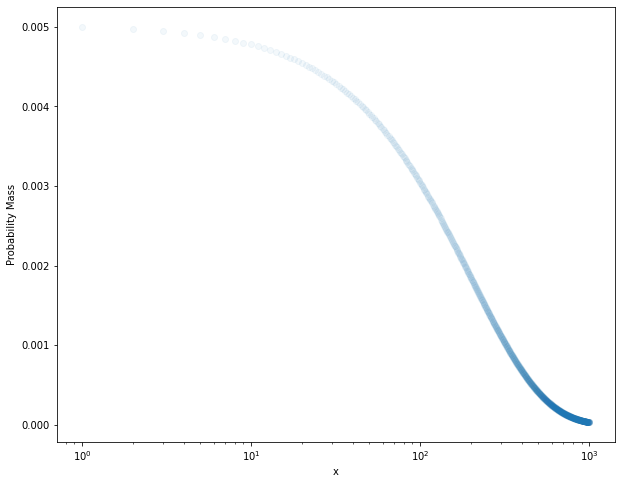

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
x = np.arange(1, 1000, 1)
y = (stats.geom
          .pmf(x, p=0.005))
ax.plot(x, y, 'o', alpha=0.05)
ax.set_xscale("log")
ax.set_xlabel("x")
ax.set_ylabel("Probability Mass")
plt.show()

In [107]:
(stats.geom(p=0.005)
      .rvs(100))

array([  34,  131,   53,   50,  182,   28,   10, 1049,  383,   70,  161,
          5,  589,  252,  316,  348,  231,  169,  144,  393,   79,  126,
        257,   47,  422,  137,   51,  167,  285,  223,    2,   46,    3,
         20,  203,  209,   55,   69,  385,  465,  358,   36,  152,  200,
         34,  334,  351,  336,   43,  139,  164,  592,   64,  145,  193,
        346,  132,  152,   47,  235,   58,  265,    9,  223,   22,  531,
        546,  135,  150,  566,   30,   15,  184,   17,  122,   93,  378,
        221,   21,  180,  174,   61,   27,  110,  145,   59,  354,   75,
        153,  147,  164,  115,  313,  101,  246,   76,  104,  114,  383,
        224])

### Beta Continuous Distribution

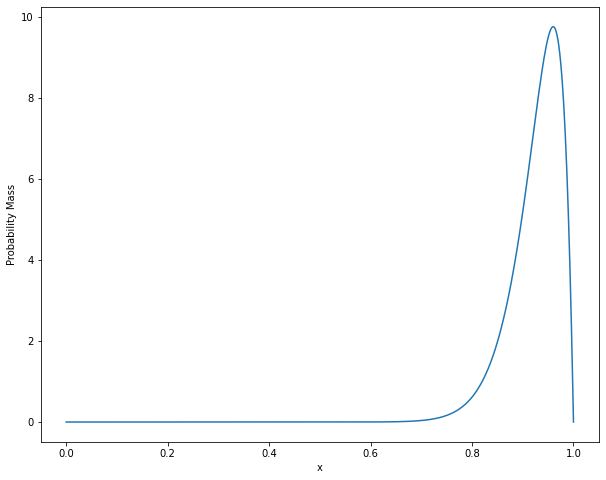

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
x = np.linspace(0, 1, 1000)
y = (stats.beta
          .pdf(x, a=25, b=2))
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("Probability Mass")
plt.show()

In [109]:
(stats.beta(a=100, b=10)
      .rvs(100))

array([0.92400297, 0.90460125, 0.89038182, 0.94580268, 0.91804298,
       0.867464  , 0.90441005, 0.91186593, 0.90951299, 0.89103939,
       0.94349082, 0.83167158, 0.91222321, 0.90794772, 0.93286381,
       0.92936291, 0.94372797, 0.86268936, 0.89195736, 0.94982185,
       0.85605981, 0.94931195, 0.92583966, 0.94219413, 0.95965116,
       0.93384184, 0.91626515, 0.94070644, 0.92602395, 0.89578039,
       0.90487476, 0.94108573, 0.93514655, 0.92332983, 0.86713237,
       0.91535837, 0.92835292, 0.87488484, 0.92243434, 0.96307026,
       0.89646717, 0.89368342, 0.91685661, 0.90396868, 0.90113567,
       0.93302327, 0.94131227, 0.8784183 , 0.90887293, 0.90565314,
       0.86457873, 0.93408108, 0.94287587, 0.88343723, 0.95183255,
       0.9568796 , 0.89771568, 0.95766849, 0.92359455, 0.85889203,
       0.88586911, 0.945116  , 0.93245336, 0.8936076 , 0.91144989,
       0.85894877, 0.85181564, 0.90069653, 0.93498123, 0.94354779,
       0.89612976, 0.9120057 , 0.95755626, 0.89244016, 0.93022

### Exercise: Playing with probability distributions

Play around with the parameters of the distributions above and see if you can get a feel for how the shape of the pmf/pdf changes with different parameter values.

In [110]:
_seed = generate_seed()
_pca_default_hyperparameters = {
    "random_state": np.random.RandomState(_seed),
    "whiten": False,
}

_seed = generate_seed()
_classifier_default_hyperparameters = {
    "bootstrap": False,
    "oob_score": False,
    "max_samples": None,
    "n_jobs": -1,
    "random_state": np.random.RandomState(_seed),
}

_pipeline = pipeline.make_pipeline(
    decomposition.PCA(
        **_pca_default_hyperparameters
    ),
    ensemble.RandomForestClassifier(
        **_classifier_default_hyperparameters
    ),
    verbose=True,
    memory="../results/models", # enables on-disk caching!
)


_parameter_distributions = [
    {
        "pca__n_components": stats.beta(a=100, b=10),
        "randomforestclassifier__n_estimators": stats.geom(p=0.005),
        "randomforestclassifier__min_samples_split": stats.beta(a=2, b=100),
    }
]

_seed = generate_seed()
estimator = model_selection.RandomizedSearchCV(
    _pipeline,
    _parameter_distributions,
    cv=CV_FOLDS,
    n_iter=10, # 3 * 10 = 30 total fits!
    n_jobs=-1,
    pre_dispatch=2, # important to set this properly to avoid OOM errors
    random_state=np.random.RandomState(_seed),
    scoring="accuracy",
    verbose=1
)

In [111]:
_ = estimator.fit(train_features, train_target)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Pipeline] ............... (step 1 of 2) Processing pca, total=  14.0s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total= 3.8min


In [112]:
estimator.best_score_

0.9037301587301587

In [113]:
estimator.best_params_

{'pca__n_components': 0.9205949285800195,
 'randomforestclassifier__min_samples_split': 0.009067403182697253,
 'randomforestclassifier__n_estimators': 251}

In [114]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
_ = joblib.dump(estimator, RESULTS_DIR / f"randomized-search-cv-classifier-{timestamp}.pkl")

### Exercise:

Fine-tune one of your models using Grid Search; fine-tune another model using Randomized Search.

In [115]:
# insert your code here!

# Evaluate your models on the test dataset

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set.

In [116]:
# make predictions
predictions = estimator.predict(test_features)

# generate a classification report
_report = metrics.classification_report(
    test_target,
    predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       711
           1       0.96      0.96      0.96       794
           2       0.88      0.88      0.88       726
           3       0.83      0.88      0.85       733
           4       0.90      0.88      0.89       611
           5       0.86      0.87      0.87       617
           6       0.93      0.95      0.94       713
           7       0.92      0.89      0.90       714
           8       0.85      0.82      0.84       704
           9       0.89      0.87      0.88       677

    accuracy                           0.90      7000
   macro avg       0.90      0.89      0.89      7000
weighted avg       0.90      0.90      0.90      7000



If you did a lot of hyperparameter tuning, the performance will usually be slightly worse than what you measured using cross-validation (because your system ends up fine-tuned to perform well on the validation data and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.